In [13]:
import cv2
import numpy as np
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
import os
import pandas as pd
from collections import deque
from tensorflow.keras.models import load_model
from google.colab import drive
import tensorflow as tf

# Montar Google Drive
drive.mount('/content/drive')

# Definir intervalos de corte para frames coloridos e térmicos
color_crop_rows = (0, 720)
color_crop_cols = (250, 500)
thermal_crop_rows = (0, 512)
thermal_crop_cols = (0, 250)

# Definir range de frames para inferência
detection_start_frame = 1500
detection_end_frame = 1600

# Função para cortar o frame
def crop_frame(frame, crop_rows, crop_cols):
    return frame[crop_rows[0]:crop_rows[1], crop_cols[0]:crop_cols[1]]

# Caminhos para os vídeos coloridos e térmicos
color_video_path = '/content/drive/MyDrive/approach_nwot/videos/video_colorido_concatenado_10fps.mp4'
thermal_video_path = '/content/drive/MyDrive/approach_nwot/videos/video_preto_branco_10fps.mp4'

# Caminho para o modelo de detecção de cabeça e segmentação de olhos
model_path = '/content/drive/MyDrive/approach_nwot/models/modelo_deteccao_cabeca_completo.pth'
model2_path = '/content/drive/MyDrive/data/saved_model/my_model.keras'

# Carregar o modelo de detecção de cabeça
def load_complete_model(model_path):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model = torch.load(model_path, map_location=device)
    model.to(device)
    model.eval()
    return model, device

model, device = load_complete_model(model_path)

# Carregar o modelo de segmentação de olhos
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice

model2_carregado = load_model(model2_path, custom_objects={'dice_loss': dice_loss})

# Inicializar captura de vídeo
color_cap = cv2.VideoCapture(color_video_path)
thermal_cap = cv2.VideoCapture(thermal_video_path)

# Definir o tamanho dos blocos e calcular o número de blocos
block_size = 50
thermal_height, thermal_width = thermal_crop_rows[1] - thermal_crop_rows[0], thermal_crop_cols[1] - thermal_crop_cols[0]
num_blocks_vert = int(np.ceil(thermal_height / block_size))
num_blocks_hor = int(np.ceil(thermal_width / block_size))

# Criar uma grade de blocos
blocks = []
for row in range(num_blocks_vert):
    for col in range(num_blocks_hor):
        y_start = row * block_size
        y_end = min((row + 1) * block_size, thermal_height)
        x_start = col * block_size
        x_end = min((col + 1) * block_size, thermal_width)
        blocks.append({
            'row': row,
            'col': col,
            'y_start': y_start,
            'y_end': y_end,
            'x_start': x_start,
            'x_end': x_end,
            'deltaX': 0,
            'deltaY': 0
        })

# Definir deslocamentos específicos para alguns blocos
blocks_shifts = {
    (0, 0): {'deltaX': 10, 'deltaY': 35},
    (0, 1): {'deltaX': 20, 'deltaY': 80},
    (0, 2): {'deltaX': 20, 'deltaY': 80},
    (0, 3): {'deltaX': 20, 'deltaY': 80},
    (0, 4): {'deltaX': 20, 'deltaY': 80},
    (1, 0): {'deltaX': 20, 'deltaY': 60},
    (1, 1): {'deltaX': 20, 'deltaY': 80},
    (1, 2): {'deltaX': 20, 'deltaY': 80},
    (1, 3): {'deltaX': 20, 'deltaY': 80},
    (1,4 ): {'deltaX': 20, 'deltaY': 80},
    (2, 0): {'deltaX': 20, 'deltaY': 90},
    (2, 1): {'deltaX': 10, 'deltaY': 60},
    (2, 2): {'deltaX': 10, 'deltaY': 60},
    (2, 3): {'deltaX': 20, 'deltaY': 60},
    (2,4 ): {'deltaX': 20, 'deltaY': 80},
    (3, 0): {'deltaX': 20, 'deltaY': 80},
    (3, 1): {'deltaX': 10, 'deltaY': 80},
    (3, 2): {'deltaX': 20, 'deltaY': 90},
    (3, 3): {'deltaX': 30, 'deltaY': 90},
    (3,4 ): {'deltaX': 30, 'deltaY': 80},
    (4, 0): {'deltaX': 20, 'deltaY': 100},
    (4, 1): {'deltaX': 5, 'deltaY': 110},
    (4, 2): {'deltaX': 15, 'deltaY': 90},
    (4, 3): {'deltaX': 15, 'deltaY': 100},
    (4,4 ): {'deltaX': 20, 'deltaY': 100},
    (5, 0): {'deltaX': 20, 'deltaY': 100},
    (5, 1): {'deltaX': 35, 'deltaY': 90},
    (5, 2): {'deltaX': 30, 'deltaY': 100},
    (5, 3): {'deltaX': 25, 'deltaY': 105},
    (5,4 ): {'deltaX': 20, 'deltaY': 100},
    (6, 0): {'deltaX': 20, 'deltaY': 100},
    (6, 1): {'deltaX': 20, 'deltaY': 70},
    (6, 2): {'deltaX': 20, 'deltaY': 100},
    (6, 3): {'deltaX': 20, 'deltaY': 80},
    (6,4 ): {'deltaX': 40, 'deltaY': 100},
    (7, 0): {'deltaX': 20, 'deltaY': 100},
    (7, 1): {'deltaX': 10, 'deltaY': 85},
    (7, 2): {'deltaX': 10, 'deltaY': 80},
    (7, 3): {'deltaX': 25, 'deltaY': 90},
    (7, 4): {'deltaX': 20, 'deltaY': 100},
    (8, 0): {'deltaX': 20, 'deltaY': 100},
    (8, 1): {'deltaX': 20, 'deltaY': 80},
    (8, 2): {'deltaX': 10, 'deltaY': 100},
    (8, 3): {'deltaX': 10, 'deltaY': 100},
    (8, 4): {'deltaX': 30, 'deltaY': 100},
    (9, 0): {'deltaX': 20, 'deltaY': 100},
    (9, 1): {'deltaX': 20, 'deltaY': 100},
    (9, 2): {'deltaX': 20, 'deltaY': 100},
    (9, 3): {'deltaX': 20, 'deltaY': 100},
    (9, 4): {'deltaX': 30, 'deltaY': 100},
    (10, 0): {'deltaX': 10, 'deltaY': 100},
    (10, 1): {'deltaX': 10, 'deltaY': 100},
    (10, 2): {'deltaX': 10, 'deltaY': 100},
    (10, 3): {'deltaX': 10, 'deltaY': 100},
}

# Atualizar os deltaX e deltaY nos blocos com base no mapeamento definido
for block in blocks:
    key = (block['row'], block['col'])
    if key in blocks_shifts:
        block['deltaX'] = blocks_shifts[key]['deltaX']
        block['deltaY'] = blocks_shifts[key]['deltaY']

# Função para determinar o bloco de uma caixa delimitadora
def get_block_of_box(box, blocks):
    x_center = (box[0] + box[2]) / 2
    y_center = (box[1] + box[3]) / 2

    for block in blocks:
        if (block['x_start'] <= x_center < block['x_end']) and (block['y_start'] <= y_center < block['y_end']):
            return (block['row'], block['col'])

    return None

# Inicializar variáveis para tracking
cow_id_counter = 0
cow_ids = {}
tracking_data = []
iou_threshold = 0.3
distance_threshold = 50
conf_threshold = 0.5
history_length = 5
max_age = 3
cow_history = {}
cow_age = {}
max_temperatures = {}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-13-4044b952d0c2>:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=device)


In [14]:
# Função para calcular IoU entre duas caixas delimitadoras
def compute_iou(box1, box2):
    """
    Calcula a Interseção sobre a União (IoU) entre duas caixas delimitadoras.

    Args:
        box1 (list ou array): [x1, y1, x2, y2]
        box2 (list ou array): [x1, y1, x2, y2]

    Returns:
        float: Valor da IoU.
    """
    x_left = max(box1[0], box2[0])
    y_top = max(box1[1], box2[1])
    x_right = min(box1[2], box2[2])
    y_bottom = min(box1[3], box2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    return iou

# Função para calcular a distância entre centróides
def compute_centroid_distance(box1, box2):
    """
    Calcula a distância Euclidiana entre os centróides de duas caixas delimitadoras.

    Args:
        box1 (list ou array): [x1, y1, x2, y2]
        box2 (list ou array): [x1, y1, x2, y2]

    Returns:
        float: Distância Euclidiana.
    """
    centroid1 = [(box1[0] + box1[2]) / 2, (box1[1] + box1[3]) / 2]
    centroid2 = [(box2[0] + box2[2]) / 2, (box2[1] + box2[3]) / 2]
    distance = np.sqrt((centroid1[0] - centroid2[0])**2 + (centroid1[1] - centroid2[1])**2)
    return distance


In [3]:
import cv2
import numpy as np
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
import os
import pandas as pd
from collections import deque
from tensorflow.keras.models import load_model
from google.colab import drive

# Montar Google Drive
drive.mount('/content/drive')

# Definir intervalos de corte para frames coloridos e térmicos
color_crop_rows = (0, 720)
color_crop_cols = (250, 500)
thermal_crop_rows = (0, 512)
thermal_crop_cols = (0, 250)

# Definir range de frames para inferência
detection_start_frame = 1500
detection_end_frame = 2000

# Função para cortar o frame
def crop_frame(frame, crop_rows, crop_cols):
    return frame[crop_rows[0]:crop_rows[1], crop_cols[0]:crop_cols[1]]

# Caminhos para os vídeos coloridos e térmicos
color_video_path = '/content/drive/MyDrive/approach_nwot/videos/video_colorido_concatenado_10fps.mp4'
thermal_video_path = '/content/drive/MyDrive/approach_nwot/videos/video_preto_branco_10fps.mp4'

# Caminho para o modelo de detecção de cabeça e segmentação de olhos
model_path = '/content/drive/MyDrive/approach_nwot/models/modelo_deteccao_cabeca_completo.pth'
model2_path = '/content/drive/MyDrive/data/saved_model/my_model.keras'

# Carregar o modelo de detecção de cabeça
def load_complete_model(model_path):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model = torch.load(model_path, map_location=device)
    model.to(device)
    model.eval()
    return model, device

model, device = load_complete_model(model_path)

# Carregar o modelo de segmentação de olhos
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice

model2_carregado = load_model(model2_path, custom_objects={'dice_loss': dice_loss})

# Inicializar captura de vídeo
color_cap = cv2.VideoCapture(color_video_path)
thermal_cap = cv2.VideoCapture(thermal_video_path)

# Definir o tamanho dos blocos e calcular o número de blocos
block_size = 50
thermal_height, thermal_width = thermal_crop_rows[1] - thermal_crop_rows[0], thermal_crop_cols[1] - thermal_crop_cols[0]
num_blocks_vert = int(np.ceil(thermal_height / block_size))
num_blocks_hor = int(np.ceil(thermal_width / block_size))

# Criar uma grade de blocos
blocks = []
for row in range(num_blocks_vert):
    for col in range(num_blocks_hor):
        y_start = row * block_size
        y_end = min((row + 1) * block_size, thermal_height)
        x_start = col * block_size
        x_end = min((col + 1) * block_size, thermal_width)
        blocks.append({
            'row': row,
            'col': col,
            'y_start': y_start,
            'y_end': y_end,
            'x_start': x_start,
            'x_end': x_end,
            'deltaX': 0,
            'deltaY': 0
        })

# Definir deslocamentos específicos para alguns blocos
blocks_shifts = {
    (0, 0): {'deltaX': 10, 'deltaY': 35},
    (0, 1): {'deltaX': 20, 'deltaY': 80},
    (0, 2): {'deltaX': 20, 'deltaY': 80},
    (0, 3): {'deltaX': 20, 'deltaY': 80},
    (0, 4): {'deltaX': 20, 'deltaY': 80},
    (1, 0): {'deltaX': 20, 'deltaY': 60},
    (1, 1): {'deltaX': 20, 'deltaY': 80},
    (1, 2): {'deltaX': 20, 'deltaY': 80},
    (1, 3): {'deltaX': 20, 'deltaY': 80},
    (1, 4): {'deltaX': 20, 'deltaY': 80},
    (2, 0): {'deltaX': 20, 'deltaY': 90},
    (2, 1): {'deltaX': 10, 'deltaY': 60},
    (2, 2): {'deltaX': 10, 'deltaY': 60},
    (2, 3): {'deltaX': 20, 'deltaY': 60},
    (2, 4): {'deltaX': 20, 'deltaY': 80},
    (3, 0): {'deltaX': 20, 'deltaY': 80},
    (3, 1): {'deltaX': 10, 'deltaY': 80},
    (3, 2): {'deltaX': 20, 'deltaY': 90},
    (3, 3): {'deltaX': 30, 'deltaY': 90},
    (3, 4): {'deltaX': 30, 'deltaY': 80},
    (4, 0): {'deltaX': 20, 'deltaY': 100},
    (4, 1): {'deltaX': 5, 'deltaY': 110},
    (4, 2): {'deltaX': 15, 'deltaY': 90},
    (4, 3): {'deltaX': 15, 'deltaY': 100},
    (4, 4): {'deltaX': 20, 'deltaY': 100},
    (5, 0): {'deltaX': 20, 'deltaY': 100},
    (5, 1): {'deltaX': 35, 'deltaY': 90},
    (5, 2): {'deltaX': 30, 'deltaY': 100},
    (5, 3): {'deltaX': 25, 'deltaY': 105},
    (5, 4): {'deltaX': 20, 'deltaY': 100},
    (6, 0): {'deltaX': 20, 'deltaY': 100},
    (6, 1): {'deltaX': 20, 'deltaY': 70},
    (6, 2): {'deltaX': 20, 'deltaY': 100},
    (6, 3): {'deltaX': 20, 'deltaY': 80},
    (6, 4): {'deltaX': 40, 'deltaY': 100},
    (7, 0): {'deltaX': 20, 'deltaY': 100},
    (7, 1): {'deltaX': 10, 'deltaY': 85},
    (7, 2): {'deltaX': 10, 'deltaY': 80},
    (7, 3): {'deltaX': 25, 'deltaY': 90},
    (7, 4): {'deltaX': 20, 'deltaY': 100},
    (8, 0): {'deltaX': 20, 'deltaY': 100},
    (8, 1): {'deltaX': 20, 'deltaY': 80},
    (8, 2): {'deltaX': 10, 'deltaY': 100},
    (8, 3): {'deltaX': 10, 'deltaY': 100},
    (8, 4): {'deltaX': 30, 'deltaY': 100},
    (9, 0): {'deltaX': 20, 'deltaY': 100},
    (9, 1): {'deltaX': 20, 'deltaY': 100},
    (9, 2): {'deltaX': 20, 'deltaY': 100},
    (9, 3): {'deltaX': 20, 'deltaY': 100},
    (9, 4): {'deltaX': 30, 'deltaY': 100},
    (10, 0): {'deltaX': 10, 'deltaY': 100},
    (10, 1): {'deltaX': 10, 'deltaY': 100},
    (10, 2): {'deltaX': 10, 'deltaY': 100},
    (10, 3): {'deltaX': 10, 'deltaY': 100},
}

# Atualizar os deltaX e deltaY nos blocos com base no mapeamento definido
for block in blocks:
    key = (block['row'], block['col'])
    if key in blocks_shifts:
        block['deltaX'] = blocks_shifts[key]['deltaX']
        block['deltaY'] = blocks_shifts[key]['deltaY']

# Função para determinar o bloco de uma caixa delimitadora
def get_block_of_box(box, blocks):
    x_center = (box[0] + box[2]) / 2
    y_center = (box[1] + box[3]) / 2

    for block in blocks:
        if (block['x_start'] <= x_center < block['x_end']) and (block['y_start'] <= y_center < block['y_end']):
            return (block['row'], block['col'])

    return None

# Função para calcular IoU entre duas caixas delimitadoras
def compute_iou(box1, box2):
    x_left = max(box1[0], box2[0])
    y_top = max(box1[1], box2[1])
    x_right = min(box1[2], box2[2])
    y_bottom = min(box1[3], box2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    return iou

# Função para calcular a distância entre centróides
def compute_centroid_distance(box1, box2):
    centroid1 = [(box1[0] + box1[2]) / 2, (box1[1] + box1[3]) / 2]
    centroid2 = [(box2[0] + box2[2]) / 2, (box2[1] + box2[3]) / 2]
    distance = np.sqrt((centroid1[0] - centroid2[0])**2 + (centroid1[1] - centroid2[1])**2)
    return distance

# Inicializar variáveis para tracking
cow_id_counter = 0
cow_ids = {}
tracking_data = []
iou_threshold = 0.3
distance_threshold = 50
conf_threshold = 0.5
history_length = 5
max_age = 3
cow_history = {}
cow_age = {}
max_temperatures = {}


# Loop para processar os frames dos vídeos
for frame_num in range(detection_start_frame, detection_end_frame):
    # Posicionar no frame desejado
    color_cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
    thermal_cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)

    ret_color, color_frame = color_cap.read()
    ret_thermal, thermal_frame = thermal_cap.read()

    if not ret_color or not ret_thermal:
        break

    # Aplicar corte nos frames
    color_cropped = crop_frame(color_frame, color_crop_rows, color_crop_cols)
    thermal_cropped = crop_frame(thermal_frame, thermal_crop_rows, thermal_crop_cols)

    # Converter o frame colorido cortado para RGB e tensor
    img_rgb = cv2.cvtColor(color_cropped, cv2.COLOR_BGR2RGB)
    img_tensor = T.ToTensor()(img_rgb).to(device)

    # Realizar detecção de cabeça no frame colorido
    with torch.no_grad():
        detections = model([img_tensor])

    # Extrair caixas, scores e labels
    boxes = detections[0]['boxes'].cpu().numpy()
    scores = detections[0]['scores'].cpu().numpy()

    # Filtrar detecções por confiança
    indices = np.where(scores > conf_threshold)[0]
    heads = boxes[indices]

    current_heads = []
    current_ids = []
    matched_ids = set()

    # Para cada detecção atual, tentar encontrar correspondência com IDs existentes
    for box in heads:
        best_iou = 0
        best_id = None
        best_distance = float('inf')

        for cid, history in cow_history.items():
            for prev_box in list(history)[-history_length:]:
                iou = compute_iou(box, prev_box)
                distance = compute_centroid_distance(box, prev_box)
                if iou > best_iou and distance < best_distance:
                    best_iou = iou
                    best_id = cid
                    best_distance = distance

        if best_iou > iou_threshold and best_distance < distance_threshold and best_id not in matched_ids:
            current_heads.append(box)
            current_ids.append(best_id)
            matched_ids.add(best_id)
            cow_history[best_id].append(box)
            cow_age[best_id] = 0
        else:
            cow_id_counter += 1
            current_heads.append(box)
            current_ids.append(cow_id_counter)
            matched_ids.add(cow_id_counter)
            cow_history[cow_id_counter] = deque(maxlen=history_length)
            cow_history[cow_id_counter].append(box)
            cow_age[cow_id_counter] = 0
            max_temperatures[cow_id_counter] = -np.inf

    # Incrementar a idade de todos os IDs que não foram correspondidos neste frame
    for cid in list(cow_age.keys()):
        if cid not in matched_ids:
            cow_age[cid] += 1
            if cow_age[cid] > max_age:
                del cow_history[cid]
                del cow_age[cid]
                del max_temperatures[cid]

    # Atualizar cow_ids com os IDs atuais
    cow_ids = {cid: box for cid, box in zip(current_ids, current_heads)}

    # Aplicar deslocamentos com base nos blocos do frame colorido
    for i, (x_min, y_min, x_max, y_max) in enumerate(current_heads):
        block_key = get_block_of_box((x_min, y_min, x_max, y_max), blocks)
        if block_key is not None:
            block = next((b for b in blocks if (b['row'], b['col']) == block_key), None)
            if block:
                deltaX = block['deltaX']
                deltaY = block['deltaY']
                translation_matrix = np.float32([[1, 0, deltaX], [0, 1, deltaY]])
                thermal_cropped = cv2.warpAffine(thermal_cropped, translation_matrix, (thermal_cropped.shape[1], thermal_cropped.shape[0]))

    # Realizar segmentação de olhos no frame térmico
    for (x_min, y_min, x_max, y_max), cid in zip(current_heads, current_ids):
        eye_crop = thermal_cropped[int(y_min):int(y_max), int(x_min):int(x_max)]
        if eye_crop.size == 0:
            continue

        # Redimensionar o crop para o tamanho esperado pelo modelo de segmentação
        eye_crop_resized = cv2.resize(eye_crop, (128, 128)) / 255.0
        eye_crop_resized = np.expand_dims(eye_crop_resized, axis=0)

        # Realizar segmentação
        mask = model2_carregado.predict(eye_crop_resized, batch_size=1)
        mask = np.squeeze(mask)
        mask = (mask > 0.5).astype(np.uint8)

        # Calcular a temperatura média dos olhos
        gray_eye_crop_resized = cv2.cvtColor((eye_crop_resized[0] * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

        masked_eye_crop = np.where(mask == 1, gray_eye_crop_resized, 0)
        max_temperature = np.max(masked_eye_crop)

        # Atualizar a temperatura máxima registrada para o bovino
        if max_temperature > max_temperatures[cid]:
            max_temperatures[cid] = max_temperature

    # Registrar dados de tracking
    for box, cid in zip(current_heads, current_ids):
        tracking_data.append({
            'frame': frame_num,
            'id': cid,
            'x1': int(box[0]),
            'y1': int(box[1]),
            'x2': int(box[2]),
            'y2': int(box[3]),
            'temperature': max_temperatures[cid]
        })


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-3-2c2f2e36c7e8>:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=device)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━

In [2]:
# Liberar capturas de vídeo e fechar janelas
color_cap.release()
thermal_cap.release()
cv2.destroyAllWindows()

# Converter os dados de tracking para DataFrame e exportar para Excel
df_tracking = pd.DataFrame(tracking_data)
excel_file = '/content/drive/MyDrive/approach_nwot/tracking_data.xlsx'
df_tracking.to_excel(excel_file, index=False)
print(f"Dados de tracking salvos em {excel_file}")

Dados de tracking salvos em /content/drive/MyDrive/approach_nwot/tracking_data.xlsx


In [28]:
import cv2
import numpy as np
import torch
import torchvision.transforms as T
import os
import pandas as pd
from collections import deque
from tensorflow.keras.models import load_model
from google.colab import drive
import tensorflow as tf
import easyocr
import re
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

# Define crop intervals for color and thermal frames
color_crop_rows = (0, 720)
color_crop_cols = (250, 500)
thermal_crop_rows = (0, 512)
thermal_crop_cols = (0, 250)

# Define range of frames for inference
detection_start_frame = 1500
detection_end_frame = 1600

# Function to crop the frame
def crop_frame(frame, crop_rows, crop_cols):
    return frame[crop_rows[0]:crop_rows[1], crop_cols[0]:crop_cols[1]]

# Paths to the color and thermal videos
color_video_path = '/content/drive/MyDrive/approach_nwot/videos/video_colorido_concatenado_10fps.mp4'
thermal_video_path = '/content/drive/MyDrive/approach_nwot/videos/video_preto_branco_10fps.mp4'

# Paths to the head detection and eye segmentation models
model_path = '/content/drive/MyDrive/approach_nwot/models/modelo_deteccao_cabeca_completo.pth'
model2_path = '/content/drive/MyDrive/data/saved_model/my_model.keras'

# Function to load the head detection model
def load_complete_model(model_path):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model = torch.load(model_path, map_location=device)
    model.to(device)
    model.eval()
    return model, device

# Load the head detection model
model, device = load_complete_model(model_path)

# Function to define dice loss
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return 1 - dice

# Load the eye segmentation model
model2_carregado = load_model(model2_path, custom_objects={'dice_loss': dice_loss})

# Initialize video capture
color_cap = cv2.VideoCapture(color_video_path)
thermal_cap = cv2.VideoCapture(thermal_video_path)

# Define block size and calculate the number of blocks
block_size = 50
thermal_height = 512  # After resizing
thermal_width = 640   # After resizing
num_blocks_vert = int(np.ceil(thermal_height / block_size))
num_blocks_hor = int(np.ceil(thermal_width / block_size))

# Create a grid of blocks
blocks = []
for row in range(num_blocks_vert):
    for col in range(num_blocks_hor):
        y_start = row * block_size
        y_end = min((row + 1) * block_size, thermal_height)
        x_start = col * block_size
        x_end = min((col + 1) * block_size, thermal_width)
        blocks.append({
            'row': row,
            'col': col,
            'y_start': y_start,
            'y_end': y_end,
            'x_start': x_start,
            'x_end': x_end,
            'deltaX': 0,
            'deltaY': 0
        })


# Definir deslocamentos específicos para alguns blocos
blocks_shifts = {
    (0, 0): {'deltaX': 10, 'deltaY': 35},
    (0, 1): {'deltaX': 20, 'deltaY': 80},
    (0, 2): {'deltaX': 20, 'deltaY': 80},
    (0, 3): {'deltaX': 20, 'deltaY': 80},
    (0, 4): {'deltaX': 20, 'deltaY': 80},
    (1, 0): {'deltaX': 20, 'deltaY': 60},
    (1, 1): {'deltaX': 20, 'deltaY': 80},
    (1, 2): {'deltaX': 20, 'deltaY': 80},
    (1, 3): {'deltaX': 20, 'deltaY': 80},
    (1, 4): {'deltaX': 20, 'deltaY': 80},
    (2, 0): {'deltaX': 20, 'deltaY': 90},
    (2, 1): {'deltaX': 10, 'deltaY': 60},
    (2, 2): {'deltaX': 10, 'deltaY': 60},
    (2, 3): {'deltaX': 20, 'deltaY': 60},
    (2, 4): {'deltaX': 20, 'deltaY': 80},
    (3, 0): {'deltaX': 20, 'deltaY': 80},
    (3, 1): {'deltaX': 10, 'deltaY': 80},
    (3, 2): {'deltaX': 20, 'deltaY': 90},
    (3, 3): {'deltaX': 30, 'deltaY': 90},
    (3, 4): {'deltaX': 30, 'deltaY': 80},
    (4, 0): {'deltaX': 20, 'deltaY': 100},
    (4, 1): {'deltaX': 5, 'deltaY': 110},
    (4, 2): {'deltaX': 15, 'deltaY': 90},
    (4, 3): {'deltaX': 15, 'deltaY': 100},
    (4, 4): {'deltaX': 20, 'deltaY': 100},
    (5, 0): {'deltaX': 20, 'deltaY': 100},
    (5, 1): {'deltaX': 35, 'deltaY': 90},
    (5, 2): {'deltaX': 30, 'deltaY': 100},
    (5, 3): {'deltaX': 25, 'deltaY': 105},
    (5, 4): {'deltaX': 20, 'deltaY': 100},
    (6, 0): {'deltaX': 20, 'deltaY': 100},
    (6, 1): {'deltaX': 20, 'deltaY': 70},
    (6, 2): {'deltaX': 20, 'deltaY': 100},
    (6, 3): {'deltaX': 20, 'deltaY': 80},
    (6, 4): {'deltaX': 40, 'deltaY': 100},
    (7, 0): {'deltaX': 20, 'deltaY': 100},
    (7, 1): {'deltaX': 10, 'deltaY': 85},
    (7, 2): {'deltaX': 10, 'deltaY': 80},
    (7, 3): {'deltaX': 25, 'deltaY': 90},
    (7, 4): {'deltaX': 20, 'deltaY': 100},
    (8, 0): {'deltaX': 20, 'deltaY': 100},
    (8, 1): {'deltaX': 20, 'deltaY': 80},
    (8, 2): {'deltaX': 10, 'deltaY': 100},
    (8, 3): {'deltaX': 10, 'deltaY': 100},
    (8, 4): {'deltaX': 30, 'deltaY': 100},
    (9, 0): {'deltaX': 20, 'deltaY': 100},
    (9, 1): {'deltaX': 20, 'deltaY': 100},
    (9, 2): {'deltaX': 20, 'deltaY': 100},
    (9, 3): {'deltaX': 20, 'deltaY': 100},
    (9, 4): {'deltaX': 30, 'deltaY': 100},
    (10, 0): {'deltaX': 10, 'deltaY': 100},
    (10, 1): {'deltaX': 10, 'deltaY': 100},
    (10, 2): {'deltaX': 10, 'deltaY': 100},
    (10, 3): {'deltaX': 10, 'deltaY': 100},
}
# Update deltaX and deltaY in blocks based on the defined mapping
for block in blocks:
    key = (block['row'], block['col'])
    if key in blocks_shifts:
        block['deltaX'] = blocks_shifts[key]['deltaX']
        block['deltaY'] = blocks_shifts[key]['deltaY']

# Function to determine the block of a bounding box
def get_block_of_box(box, blocks):
    x_center = (box[0] + box[2]) / 2
    y_center = (box[1] + box[3]) / 2

    for block in blocks:
        if (block['x_start'] <= x_center < block['x_end']) and (block['y_start'] <= y_center < block['y_end']):
            return (block['row'], block['col'])

    return None

# Function to compute IoU between two bounding boxes
def compute_iou(box1, box2):
    x_left = max(box1[0], box2[0])
    y_top = max(box1[1], box2[1])
    x_right = min(box1[2], box2[2])
    y_bottom = min(box1[3], box2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    return iou

# Function to compute the centroid distance between two bounding boxes
def compute_centroid_distance(box1, box2):
    centroid1 = [(box1[0] + box1[2]) / 2, (box1[1] + box1[3]) / 2]
    centroid2 = [(box2[0] + box2[2]) / 2, (box2[1] + box2[3]) / 2]
    distance = np.sqrt((centroid1[0] - centroid2[0])**2 + (centroid1[1] - centroid2[1])**2)
    return distance

# Initialize variables for tracking
cow_id_counter = 0
cow_ids = {}
tracking_data = []
iou_threshold = 0.3
distance_threshold = 50
conf_threshold = 0.5
history_length = 5
max_age = 3
cow_history = {}
cow_age = {}
max_temperatures = {}

# Function to format and convert OCR text to float
def format_and_convert_to_float(ocr_text):
    cleaned_text = re.sub(r'[^\d]', '', ocr_text)
    if len(cleaned_text) >= 2:
        formatted_text = cleaned_text[:2] + '.' + cleaned_text[2:]
    else:
        formatted_text = cleaned_text + '.0'
    try:
        return float(formatted_text)
    except ValueError:
        return None

# Function to extract temperatures from the frame using OCR
def extract_temperatures_from_frame(frame, reader):
    # The frame is expected to be 640x512 after resizing

    # Fixed coordinates for temp_max and temp_min
    # temp_max: X [500:575], Y [50:120]
    # temp_min: X [500:575], Y [400:440]

    roi_temp_max = frame[50:120, 500:575]
    roi_temp_min = frame[400:440, 500:575]

    # Check if ROIs are valid
    if roi_temp_max.size == 0 or roi_temp_min.size == 0:
        print("ROI for temperature extraction is empty.")
        return None, None

    # Preprocess ROIs for better OCR accuracy
    roi_temp_max_gray = cv2.cvtColor(roi_temp_max, cv2.COLOR_BGR2GRAY)
    roi_temp_min_gray = cv2.cvtColor(roi_temp_min, cv2.COLOR_BGR2GRAY)

    # Apply thresholding to enhance text
    _, roi_temp_max_thresh = cv2.threshold(roi_temp_max_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, roi_temp_min_thresh = cv2.threshold(roi_temp_min_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Use the preprocessed images for OCR
    result_temp_max = reader.readtext(roi_temp_max_thresh)
    result_temp_min = reader.readtext(roi_temp_min_thresh)

    temp_max_text = ''.join([detection[1] for detection in result_temp_max])
    temp_min_text = ''.join([detection[1] for detection in result_temp_min])

    # Print the extracted temperature texts
    print(f"Extracted temp_max text: {temp_max_text}")
    print(f"Extracted temp_min text: {temp_min_text}")

    temp_max = format_and_convert_to_float(temp_max_text)
    temp_min = format_and_convert_to_float(temp_min_text)

    if temp_max is None or temp_min is None:
        temp_max, temp_min = None, None

    return temp_max, temp_min

# Initialize the OCR reader
reader = easyocr.Reader(['en'])

# Loop to process the frames of the videos
for frame_num in range(detection_start_frame, detection_end_frame):
    print(f"Processing frame {frame_num}")
    # Position to the desired frame
    color_cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
    thermal_cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)

    ret_color, color_frame = color_cap.read()
    ret_thermal, thermal_frame = thermal_cap.read()

    if not ret_color or not ret_thermal:
        print(f"Failed to read frame {frame_num}")
        break

    # Apply crop to the color frame
    color_cropped = crop_frame(color_frame, color_crop_rows, color_crop_cols)

    # Resize the thermal frame to 640x512
    thermal_resized = cv2.resize(thermal_frame, (640, 512))

    # Extract temp_max and temp_min from the resized thermal frame
    temp_max, temp_min = extract_temperatures_from_frame(thermal_resized, reader)

    if temp_max is not None and temp_min is not None:
        print(f"Frame {frame_num}: temp_max={temp_max}, temp_min={temp_min}")
    else:
        print(f"Failed to extract temperatures for frame {frame_num}")
        continue  # Skip processing this frame

    # Convert the cropped color frame to RGB and tensor
    img_rgb = cv2.cvtColor(color_cropped, cv2.COLOR_BGR2RGB)
    img_tensor = T.ToTensor()(img_rgb).to(device)

    # Head detection on the color frame
    with torch.no_grad():
        detections = model([img_tensor])

    # Extract boxes and scores
    boxes = detections[0]['boxes'].cpu().numpy()
    scores = detections[0]['scores'].cpu().numpy()

    # Filter detections by confidence
    indices = np.where(scores > conf_threshold)[0]
    heads = boxes[indices]

    current_heads = []
    current_ids = []
    matched_ids = set()

    # For each current detection, try to find a match with existing IDs
    for box in heads:
        best_iou = 0
        best_id = None
        best_distance = float('inf')

        for cid, history in cow_history.items():
            for prev_box in list(history)[-history_length:]:
                iou = compute_iou(box, prev_box)
                distance = compute_centroid_distance(box, prev_box)
                if iou > best_iou and distance < best_distance:
                    best_iou = iou
                    best_id = cid
                    best_distance = distance

        if best_iou > iou_threshold and best_distance < distance_threshold and best_id not in matched_ids:
            current_heads.append(box)
            current_ids.append(best_id)
            matched_ids.add(best_id)
            cow_history[best_id].append(box)
            cow_age[best_id] = 0
        else:
            cow_id_counter += 1
            current_heads.append(box)
            current_ids.append(cow_id_counter)
            matched_ids.add(cow_id_counter)
            cow_history[cow_id_counter] = deque(maxlen=history_length)
            cow_history[cow_id_counter].append(box)
            cow_age[cow_id_counter] = 0
            max_temperatures[cow_id_counter] = -np.inf

    # Increment the age of all IDs not matched in this frame
    for cid in list(cow_age.keys()):
        if cid not in matched_ids:
            cow_age[cid] += 1
            if cow_age[cid] > max_age:
                del cow_history[cid]
                del cow_age[cid]
                del max_temperatures[cid]

    # Update cow_ids with the current IDs
    cow_ids = {cid: box for cid, box in zip(current_ids, current_heads)}

    # Apply shifts based on blocks in the color frame (if needed)
    # In this example, we are not applying any shifts

    # For each detection, process the eye crop
    for (x_min, y_min, x_max, y_max), cid in zip(current_heads, current_ids):
        # Map the coordinates from color frame to thermal frame
        # Since frames might have different sizes, adjust accordingly
        # For simplicity, assume the coordinates are directly applicable

        # Extract the eye region from the thermal frame
        eye_crop = thermal_resized[int(y_min):int(y_max), int(x_min):int(x_max)]
        if eye_crop.size == 0:
            continue

        # Resize and preprocess the eye_crop
        eye_crop_resized = cv2.resize(eye_crop, (128, 128)) / 255.0
        eye_crop_resized = np.expand_dims(eye_crop_resized, axis=0)

        # Perform segmentation
        mask = model2_carregado.predict(eye_crop_resized, batch_size=1)
        mask = np.squeeze(mask)
        mask = (mask > 0.5).astype(np.uint8)

        # Compute the max intensity (brightness) in the masked area
        gray_eye_crop_resized = cv2.cvtColor((eye_crop_resized[0] * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
        masked_eye_crop = np.where(mask == 1, gray_eye_crop_resized, 0)
        max_intensity = np.max(masked_eye_crop)

        # Convert intensity to actual temperature
        temperature = temp_min + (temp_max - temp_min) * (max_intensity / 255.0)

        # Update the maximum temperature recorded for the cow
        if cid not in max_temperatures or temperature > max_temperatures[cid]:
            max_temperatures[cid] = temperature

    # Record tracking data
    for box, cid in zip(current_heads, current_ids):
        tracking_data.append({
            'frame': frame_num,
            'id': cid,
            'x1': int(box[0]),
            'y1': int(box[1]),
            'x2': int(box[2]),
            'y2': int(box[3]),
            'temperature': max_temperatures.get(cid, None)
        })

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-28-c48628fe6afe>:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=device)


Processing frame 1500
Extracted temp_max text: 37.2
Extracted temp_min text: 21.6
Frame 1500: temp_max=37.2, temp_min=21.6
Processing frame 1501
Extracted temp_max text: 37.2
Extracted temp_min text: 21.6
Frame 1501: temp_max=37.2, temp_min=21.6
Processing frame 1502
Extracted temp_max text: 37.2
Extracted temp_min text: 21.6
Frame 1502: temp_max=37.2, temp_min=21.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step
Processing frame 1503
Extracted temp_max text: 37.2
Extracted temp_min text: 21.6
Frame 1503: temp_max=37.2, temp_min=21.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Processing frame 1504
Extracted temp_max text: 37.2
Extracted temp_min text: 21.6
Frame 1504: temp_max=37.2, temp_min=21.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Processing frame 1505
Extracted temp_max text: 37.2
Extracted temp_min text: 21.6
Frame 1505: temp_max=37.2, temp_min=21.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Processing frame 1506
Extracted temp_max text: 37.5
Extracted temp_min text: 21.4
Frame 1506: temp_max=37.5, 

In [30]:
# After processing all frames, save the tracking data
df = pd.DataFrame(tracking_data)
df.to_excel('/content/drive/MyDrive/approach_nwot/tracking_data.xlsx', index=False)
print("Temperature data has been saved to '/content/drive/MyDrive/approach_nwot/tracking_data.xlsx'.")

Temperature data has been saved to '/content/drive/MyDrive/approach_nwot/tracking_data.xlsx'.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


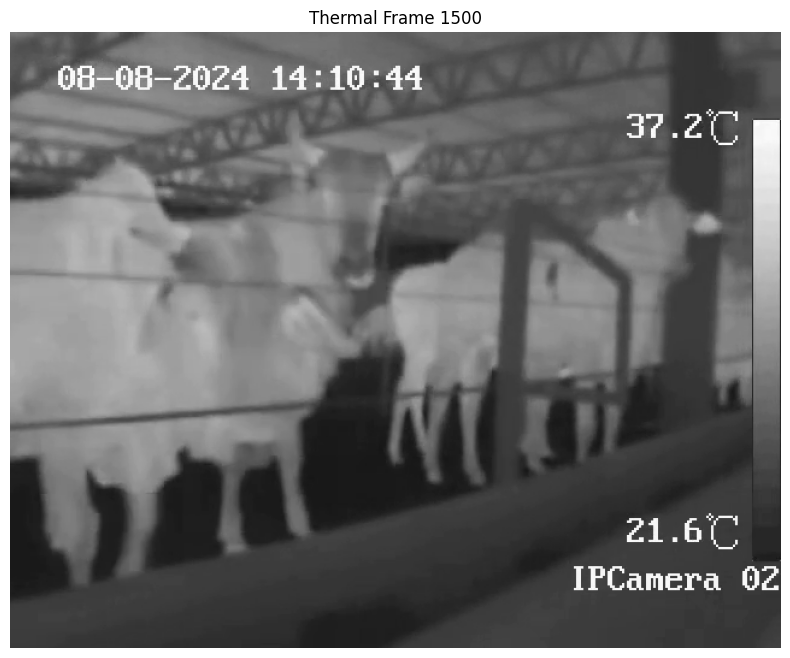

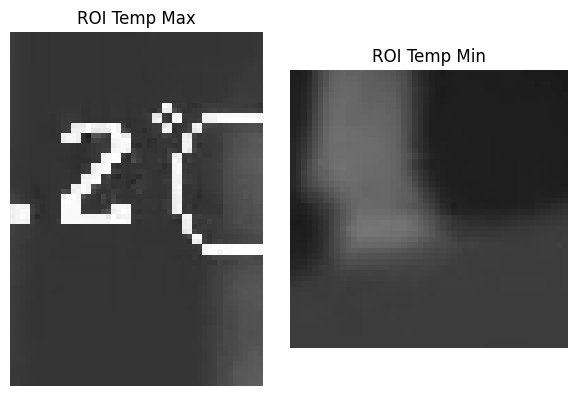

ROI Temp Max shape: (70, 50, 3)
ROI Temp Min shape: (50, 50, 3)


In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import easyocr
from google.colab import drive

# Mount Google Drive (if necessary)
drive.mount('/content/drive')

# Path to the thermal video
thermal_video_path = '/content/drive/MyDrive/approach_nwot/videos/video_preto_branco_10fps.mp4'

# Initialize video capture
thermal_cap = cv2.VideoCapture(thermal_video_path)

# Frame number to load (adjust as needed)
frame_num = 1500

# Set the frame position
thermal_cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)

# Read the frame
ret_thermal, thermal_frame = thermal_cap.read()


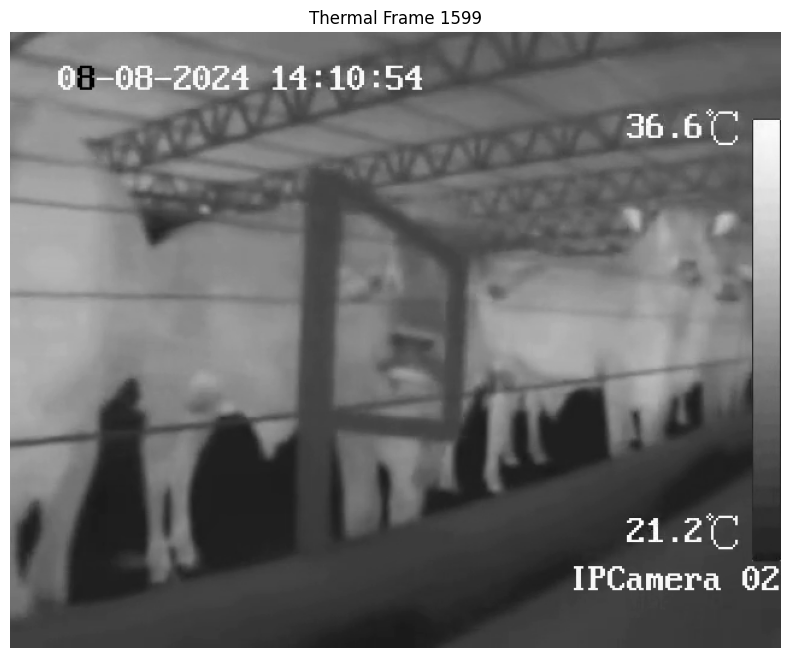

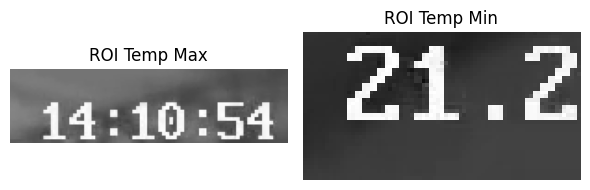

ROI Temp Max shape: (40, 150, 3)
ROI Temp Min shape: (40, 75, 3)


In [37]:

if not ret_thermal:
    print(f"Failed to read frame {frame_num}")
else:
    # Resize thermal frame to 250x512
    thermal_cropped = cv2.resize(thermal_frame, (640, 512))

    # Display the thermal frame
    plt.figure(figsize=(10, 8))
    thermal_rgb = cv2.cvtColor(thermal_cropped, cv2.COLOR_BGR2RGB)
    plt.imshow(thermal_rgb)
    plt.title(f'Thermal Frame {frame_num}')
    plt.axis('off')
    plt.show()

    # Define ROI coordinates (adjust these variables)
    # temp_max: X [x1_max:x2_max], Y [y1_max:y2_max]
    # temp_min: X [x1_min:x2_min], Y [y1_min:y2_min]

    # Initial values (you can adjust these)
    x1_max, x2_max = 200, 350
    y1_max, y2_max = 10, 50

    x1_min, x2_min = 500, 575
    y1_min, y2_min = 400, 440

    # Extract ROIs
    roi_temp_max = thermal_cropped[y1_max:y2_max, x1_max:x2_max]
    roi_temp_min = thermal_cropped[y1_min:y2_min, x1_min:x2_min]

    # Display the ROIs
    plt.figure(figsize=(6, 4))
    plt.subplot(1, 2, 1)
    roi_temp_max_rgb = cv2.cvtColor(roi_temp_max, cv2.COLOR_BGR2RGB)
    plt.imshow(roi_temp_max_rgb)
    plt.title('ROI Temp Max')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    roi_temp_min_rgb = cv2.cvtColor(roi_temp_min, cv2.COLOR_BGR2RGB)
    plt.imshow(roi_temp_min_rgb)
    plt.title('ROI Temp Min')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Optionally, print the shapes of the ROIs
    print(f"ROI Temp Max shape: {roi_temp_max.shape}")
    print(f"ROI Temp Min shape: {roi_temp_min.shape}")

    # Close the video capture
    thermal_cap.release()


In [38]:
import cv2
import numpy as np
import torch
import torchvision.transforms as T
import os
import pandas as pd
from collections import deque
from tensorflow.keras.models import load_model
from google.colab import drive
import tensorflow as tf
import easyocr
import re
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

# Define crop intervals for color and thermal frames
color_crop_rows = (0, 720)
color_crop_cols = (250, 500)
thermal_crop_rows = (0, 512)
thermal_crop_cols = (0, 250)

# Define range of frames for inference
detection_start_frame = 1500
detection_end_frame = 1600

# Function to crop the frame
def crop_frame(frame, crop_rows, crop_cols):
    return frame[crop_rows[0]:crop_rows[1], crop_cols[0]:crop_cols[1]]

# Paths to the color and thermal videos
color_video_path = '/content/drive/MyDrive/approach_nwot/videos/video_colorido_concatenado_10fps.mp4'
thermal_video_path = '/content/drive/MyDrive/approach_nwot/videos/video_preto_branco_10fps.mp4'

# Paths to the head detection and eye segmentation models
model_path = '/content/drive/MyDrive/approach_nwot/models/modelo_deteccao_cabeca_completo.pth'
model2_path = '/content/drive/MyDrive/data/saved_model/my_model.keras'

# Function to load the head detection model
def load_complete_model(model_path):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model = torch.load(model_path, map_location=device)
    model.to(device)
    model.eval()
    return model, device

# Load the head detection model
model, device = load_complete_model(model_path)

# Function to define dice loss
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return 1 - dice

# Load the eye segmentation model
model2_carregado = load_model(model2_path, custom_objects={'dice_loss': dice_loss})

# Initialize video capture
color_cap = cv2.VideoCapture(color_video_path)
thermal_cap = cv2.VideoCapture(thermal_video_path)

# Get frame rate and size from color video
fps = color_cap.get(cv2.CAP_PROP_FPS)
frame_width = int(color_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(color_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Output video writer
output_video_path = 'annotated_output_video.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out_video = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

# Initialize variables for tracking
cow_id_counter = 0
cow_ids = {}
tracking_data = []
iou_threshold = 0.3
distance_threshold = 50
conf_threshold = 0.5
history_length = 5
max_age = 3
cow_history = {}
cow_age = {}
max_temperatures = {}

# Function to format and convert OCR text to float
def format_and_convert_to_float(ocr_text):
    cleaned_text = re.sub(r'[^\d]', '', ocr_text)
    if len(cleaned_text) >= 2:
        formatted_text = cleaned_text[:2] + '.' + cleaned_text[2:]
    else:
        formatted_text = cleaned_text + '.0'
    try:
        return float(formatted_text)
    except ValueError:
        return None

# Function to extract temperatures and timestamp from the frame using OCR
def extract_temperatures_from_frame(frame, reader):
    # The frame is expected to be 640x512 after resizing

    # Fixed coordinates for temp_max and temp_min
    # temp_max: X [500:575], Y [50:120]
    # temp_min: X [500:575], Y [400:440]
    roi_temp_max = frame[50:120, 500:575]
    roi_temp_min = frame[400:440, 500:575]

    # Coordinates for timestamp extraction
    # timestamp: X [200:350], Y [10:50]
    roi_timestamp = frame[10:50, 200:350]

    # Check if ROIs are valid
    if roi_temp_max.size == 0 or roi_temp_min.size == 0 or roi_timestamp.size == 0:
        print("ROI for temperature or timestamp extraction is empty.")
        return None, None, None

    # Preprocess ROIs for better OCR accuracy
    # Temperatures
    roi_temp_max_gray = cv2.cvtColor(roi_temp_max, cv2.COLOR_BGR2GRAY)
    roi_temp_min_gray = cv2.cvtColor(roi_temp_min, cv2.COLOR_BGR2GRAY)

    _, roi_temp_max_thresh = cv2.threshold(roi_temp_max_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, roi_temp_min_thresh = cv2.threshold(roi_temp_min_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Timestamp
    roi_timestamp_gray = cv2.cvtColor(roi_timestamp, cv2.COLOR_BGR2GRAY)
    _, roi_timestamp_thresh = cv2.threshold(roi_timestamp_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Use the preprocessed images for OCR
    result_temp_max = reader.readtext(roi_temp_max_thresh)
    result_temp_min = reader.readtext(roi_temp_min_thresh)
    result_timestamp = reader.readtext(roi_timestamp_thresh)

    temp_max_text = ''.join([detection[1] for detection in result_temp_max])
    temp_min_text = ''.join([detection[1] for detection in result_temp_min])
    timestamp_text = ''.join([detection[1] for detection in result_timestamp])

    # Print the extracted texts
    print(f"Extracted temp_max text: {temp_max_text}")
    print(f"Extracted temp_min text: {temp_min_text}")
    print(f"Extracted timestamp text: {timestamp_text}")

    temp_max = format_and_convert_to_float(temp_max_text)
    temp_min = format_and_convert_to_float(temp_min_text)

    if temp_max is None or temp_min is None:
        temp_max, temp_min = None, None

    # Clean and format the timestamp text (assuming it's in HH:MM:SS format)
    timestamp_text = timestamp_text.strip()
    # Optional: Further processing to ensure the timestamp is in the correct format

    return temp_max, temp_min, timestamp_text

# Initialize the OCR reader
reader = easyocr.Reader(['en'])

# Loop to process the frames of the videos
for frame_num in range(detection_start_frame, detection_end_frame):
    print(f"Processing frame {frame_num}")
    # Position to the desired frame
    color_cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
    thermal_cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)

    ret_color, color_frame = color_cap.read()
    ret_thermal, thermal_frame = thermal_cap.read()

    if not ret_color or not ret_thermal:
        print(f"Failed to read frame {frame_num}")
        break

    # Resize the thermal frame to 640x512
    thermal_resized = cv2.resize(thermal_frame, (640, 512))

    # Extract temp_max, temp_min, and timestamp from the resized thermal frame
    temp_max, temp_min, timestamp = extract_temperatures_from_frame(thermal_resized, reader)

    if temp_max is not None and temp_min is not None and timestamp is not None:
        print(f"Frame {frame_num}: temp_max={temp_max}, temp_min={temp_min}, timestamp={timestamp}")
    else:
        print(f"Failed to extract temperatures or timestamp for frame {frame_num}")
        continue  # Skip processing this frame

    # Apply crop to the color frame
    color_cropped = crop_frame(color_frame, color_crop_rows, color_crop_cols)

    # Convert the cropped color frame to RGB and tensor
    img_rgb = cv2.cvtColor(color_cropped, cv2.COLOR_BGR2RGB)
    img_tensor = T.ToTensor()(img_rgb).to(device)

    # Head detection on the color frame
    with torch.no_grad():
        detections = model([img_tensor])

    # Extract boxes and scores
    boxes = detections[0]['boxes'].cpu().numpy()
    scores = detections[0]['scores'].cpu().numpy()

    # Filter detections by confidence
    indices = np.where(scores > conf_threshold)[0]
    heads = boxes[indices]

    current_heads = []
    current_ids = []
    matched_ids = set()

    # For each current detection, try to find a match with existing IDs
    for box in heads:
        best_iou = 0
        best_id = None
        best_distance = float('inf')

        for cid, history in cow_history.items():
            for prev_box in list(history)[-history_length:]:
                iou = compute_iou(box, prev_box)
                distance = compute_centroid_distance(box, prev_box)
                if iou > best_iou and distance < best_distance:
                    best_iou = iou
                    best_id = cid
                    best_distance = distance

        if best_iou > iou_threshold and best_distance < distance_threshold and best_id not in matched_ids:
            current_heads.append(box)
            current_ids.append(best_id)
            matched_ids.add(best_id)
            cow_history[best_id].append(box)
            cow_age[best_id] = 0
        else:
            cow_id_counter += 1
            current_heads.append(box)
            current_ids.append(cow_id_counter)
            matched_ids.add(cow_id_counter)
            cow_history[cow_id_counter] = deque(maxlen=history_length)
            cow_history[cow_id_counter].append(box)
            cow_age[cow_id_counter] = 0
            max_temperatures[cow_id_counter] = -np.inf

    # Increment the age of all IDs not matched in this frame
    for cid in list(cow_age.keys()):
        if cid not in matched_ids:
            cow_age[cid] += 1
            if cow_age[cid] > max_age:
                del cow_history[cid]
                del cow_age[cid]
                del max_temperatures[cid]

    # Update cow_ids with the current IDs
    cow_ids = {cid: box for cid, box in zip(current_ids, current_heads)}

    # Prepare to draw annotations on the original color frame (not cropped)
    annotated_frame = color_frame.copy()

    # For each detection, process the eye crop and annotate the frame
    for (x_min, y_min, x_max, y_max), cid in zip(current_heads, current_ids):
        # Map the coordinates back to the original frame size
        x_min_orig = int(x_min + color_crop_cols[0])
        y_min_orig = int(y_min + color_crop_rows[0])
        x_max_orig = int(x_max + color_crop_cols[0])
        y_max_orig = int(y_max + color_crop_rows[0])

        # Draw bounding box on the annotated frame
        cv2.rectangle(annotated_frame, (x_min_orig, y_min_orig), (x_max_orig, y_max_orig), (0, 255, 0), 2)

        # Extract the eye region from the thermal frame
        # Map coordinates to thermal frame if necessary
        # Assuming direct mapping here; adjust if needed
        eye_crop = thermal_resized[y_min_orig:y_max_orig, x_min_orig:x_max_orig]
        if eye_crop.size == 0:
            continue

        # Resize and preprocess the eye_crop
        eye_crop_resized = cv2.resize(eye_crop, (128, 128)) / 255.0
        eye_crop_resized = np.expand_dims(eye_crop_resized, axis=0)

        # Perform segmentation
        mask = model2_carregado.predict(eye_crop_resized, batch_size=1)
        mask = np.squeeze(mask)
        mask = (mask > 0.5).astype(np.uint8)

        # Compute the max intensity (brightness) in the masked area
        gray_eye_crop_resized = cv2.cvtColor((eye_crop_resized[0] * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
        masked_eye_crop = np.where(mask == 1, gray_eye_crop_resized, 0)
        max_intensity = np.max(masked_eye_crop)

        # Convert intensity to actual temperature
        temperature = temp_min + (temp_max - temp_min) * (max_intensity / 255.0)

        # Update the maximum temperature recorded for the cow
        if cid not in max_temperatures or temperature > max_temperatures[cid]:
            max_temperatures[cid] = temperature

        # Annotate the frame with cow ID and temperature
        label = f'ID: {cid}, Temp: {temperature:.2f}°C'
        cv2.putText(annotated_frame, label, (x_min_orig, y_min_orig - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Annotate the frame with the timestamp (optional)
    cv2.putText(annotated_frame, f'Time: {timestamp}', (10, frame_height - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

    # Record tracking data
    for box, cid in zip(current_heads, current_ids):
        tracking_data.append({
            'frame': frame_num,
            'timestamp': timestamp,
            'id': cid,
            'x1': int(box[0]),
            'y1': int(box[1]),
            'x2': int(box[2]),
            'y2': int(box[3]),
            'temperature': max_temperatures.get(cid, None)
        })

    # Write the annotated frame to the output video
    out_video.write(annotated_frame)

# Release video resources
color_cap.release()
thermal_cap.release()
out_video.release()

# After processing all frames, save the tracking data
df = pd.DataFrame(tracking_data)
df.to_excel('output_temperatures_with_timestamp.xlsx', index=False)
print("Temperature data with timestamps has been saved to 'output_temperatures_with_timestamp.xlsx'.")
print(f"Annotated video has been saved to '{output_video_path}'.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-38-31b953039bfa>:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=device)


Processing frame 1500
Extracted temp_max text: 37.2
Extracted temp_min text: 21.6
Extracted timestamp text: 14:10:44
Frame 1500: temp_max=37.2, temp_min=21.6, timestamp=14:10:44
Processing frame 1501
Extracted temp_max text: 37.2
Extracted temp_min text: 21.6
Extracted timestamp text: 14:10:44
Frame 1501: temp_max=37.2, temp_min=21.6, timestamp=14:10:44
Processing frame 1502
Extracted temp_max text: 37.2
Extracted temp_min text: 21.6
Extracted timestamp text: 14:10:44
Frame 1502: temp_max=37.2, temp_min=21.6, timestamp=14:10:44
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Processing frame 1503
Extracted temp_max text: 37.2
Extracted temp_min text: 21.6
Extracted timestamp text: 14:10:44
Frame 1503: temp_max=37.2, temp_min=21.6, timestamp=14:10:44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Processing frame 1504
Extracted temp_max text: 37.2
Extracted temp_min text: 21.6
Extracted timestamp text: 14:10:44
Frame 1504: temp_max=37.2, temp_min=21.6, timestamp=14:10:44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/ste